# Using Deep Learning approach 
Without dimensionality reduction based approach

## Reading the data

In [1]:
# for mounting drive with google colabs
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22278 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:
!mkdir -p  drive
!google-drive-ocamlfuse drive

In [1]:
!ls

adc.json  drive  sample_data


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
plt.style.use('ggplot')
% matplotlib inline

In [0]:
data_train = pd.read_csv('drive/data/training.csv')

In [0]:
data_test = pd.read_csv('drive/data/test.csv')

In [5]:
print(data_train.shape, data_test.shape)

(7049, 31) (1783, 2)


In [8]:
print(data_train.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [9]:
data_train.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [10]:
data_train.keys()

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

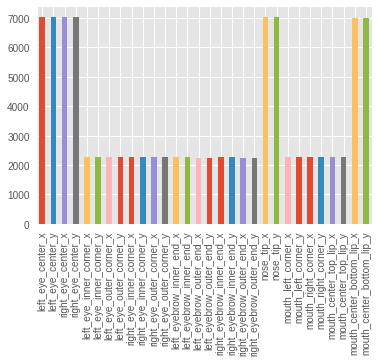

In [11]:
data_train.describe().loc['count'].plot.bar()

In [12]:
data_train = data_train.dropna()
data_train.shape

(2140, 31)

In [0]:
def string2image(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces_with_keypoints(df, nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    keypoint_cols = list(df.columns)[:-1]
    keypoints = df.loc[selection][keypoint_cols]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2image(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'ro')
        ax.axis('off')

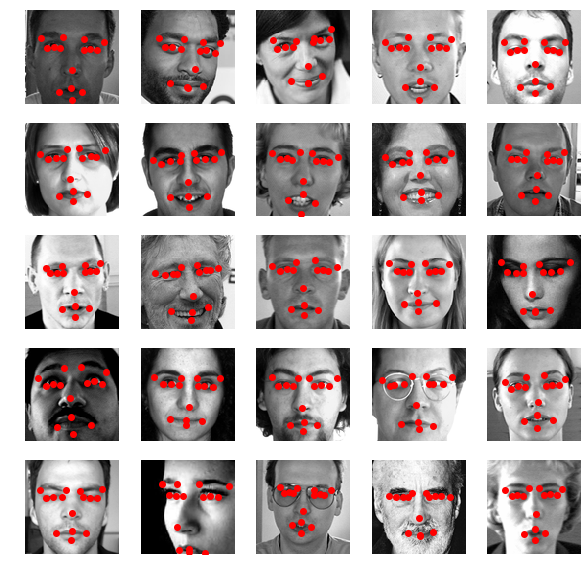

In [16]:
plot_faces_with_keypoints(data_train)

In [0]:
train_key_points_y = np.array(data_train.iloc[:,0:-1]).astype(np.float32)
train_images = data_train.iloc[:,-1]
test_images = data_test.iloc[:, -1]

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

train_key_points = output_pipe.fit_transform(train_key_points_y)

In [21]:
train_images = train_images.reshape(-1,1)
test_images = test_images.reshape(-1,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [22]:
print(train_images.shape, test_images.shape, train_key_points.shape)

(2140, 1) (1783, 1) (2140, 30)


In [0]:
def reform_data(img_str):
    t1 = img_str[0].split()
    t2 = np.array(t1).astype(np.float32)
    t3 = t2.reshape(96,96,1)
    return t3/255
train_images = np.apply_along_axis(reform_data,1, train_images)
test_images = np.apply_along_axis(reform_data,1, test_images)

In [24]:
print(train_images.shape, test_images.shape, train_key_points.shape)

(2140, 96, 96, 1) (1783, 96, 96, 1) (2140, 30)


### The images are stored in test_image, train_image which is a 96x96 dimensional vector converted image and all the X and Y coordinates of key point features is mentioned in train_key_points, test_key_points
### The key features are 
'left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'

In [0]:
# Free the memory
del data_test
del data_train

[31.76355, 64.52895, 37.75194, 25.79792, 59.747345, 70.42627, 40.41598, 18.860832, 56.688843, 77.27841, 48.90265, 32.569893, 56.972115, 44.81877, 44.69832] [36.602955, 39.198685, 37.718666, 37.30881, 38.788834, 40.177776, 31.864136, 31.864136, 33.227306, 32.94331, 62.21159, 79.00917, 81.87514, 80.27186, 81.688225]


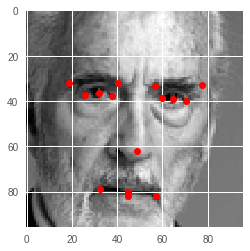

In [149]:
def show_img(img, keypoint=None):
# Sample images
  img = img.reshape(96,96)
  
  if keypoint is not None:
    x = []
    y = []
    for i in range(0,30,2):
        x.append(keypoint[i])
        y.append(keypoint[i+1])

    print(x,y)
    plt.figure()
    plt.plot(x,y, marker='o',linestyle='', color='r', label = "keypoints",)
  plt.imshow(img, cmap='gray')
  

import random
# k = random.randint(0,2000)
t_img = train_images[k]
t_kpnts = train_key_points_y[k]
show_img(cv2.flip(t_img,1), t_kpnts)

In [0]:
def data_augmentation(img_data, img_keypoints):
  new_data = list(img_data)
  new_keypoints = list(img_keypoints)
  for img, keypnt in zip(img_data, img_keypoints):
    new_data.append(cv2.flip(img, 1).reshape(96,96,1))
    for i in range(0,keypnt.shape[0],1):
      keypnt[i] = 96 - keypnt[i]
    new_keypoints.append(keypnt)
    
  return np.array(new_data), output_pipe.fit_transform(np.array(new_keypoints))

train_images_1, train_keypoints_1 = data_augmentation(train_images, train_key_points_y)

In [27]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten

Using TensorFlow backend.


In [0]:
def create_model():
  model = Sequential()
  # input layer
  model.add(BatchNormalization(input_shape=(96, 96, 1)))
  model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.2))
  # layer 2
  model.add(Conv2D(36, (5, 5)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.2))
  # layer 3
  model.add(Conv2D(48, (5, 5)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.2))
  # layer 4
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.2))
  # layer 5
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(Flatten())
  # layer 6
  model.add(Dense(500, activation="relu"))
  # layer 7
  model.add(Dense(90, activation="relu"))
  # layer 8
  model.add(Dense(30))
  return model

In [194]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_14 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 92, 92, 24)        624       
_________________________________________________________________
activation_65 (Activation)   (None, 92, 92, 24)        0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 46, 46, 24)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 46, 46, 24)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 42, 42, 36)        21636     
_________________________________________________________________
activation_66 (Activation)   (None, 42, 42, 36)        0         
__________

In [0]:
model.load_weights('drive/data/facial_keypoint_weights.h5')

In [0]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.1, decay=1e-5, momentum=0.96, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['mae'])
json_model = model.to_json()

# with open("model.json", "w") as json_file:
#     json_file.write(json_model)
    


In [196]:
epochs = 100
history = model.fit(train_images_1, train_keypoints_1, 
                 validation_split=0.3, shuffle=True, 
                 epochs=epochs, batch_size=128)

Train on 2996 samples, validate on 1284 samples
Epoch 1/100
2996/2996 [==============================] - 3s 1ms/step - loss: 0.0581 - mean_absolute_error: 0.1712 - val_loss: 0.0438 - val_mean_absolute_error: 0.1524
Epoch 2/100
2996/2996 [==============================] - 2s 584us/step - loss: 0.0343 - mean_absolute_error: 0.1336 - val_loss: 0.0432 - val_mean_absolute_error: 0.1492
Epoch 3/100
2996/2996 [==============================] - 2s 585us/step - loss: 0.0339 - mean_absolute_error: 0.1321 - val_loss: 0.0429 - val_mean_absolute_error: 0.1487
Epoch 4/100
2996/2996 [==============================] - 2s 589us/step - loss: 0.0338 - mean_absolute_error: 0.1320 - val_loss: 0.0428 - val_mean_absolute_error: 0.1484
Epoch 5/100
2996/2996 [==============================] - 2s 591us/step - loss: 0.0338 - mean_absolute_error: 0.1319 - val_loss: 0.0428 - val_mean_absolute_error: 0.1485
Epoch 6/100
2996/2996 [==============================] - 2s 592us/step - loss: 0.0338 - mean_absolute_error: 

In [0]:
model.save_weights('drive/data/facial_keypoint_weights.h5')

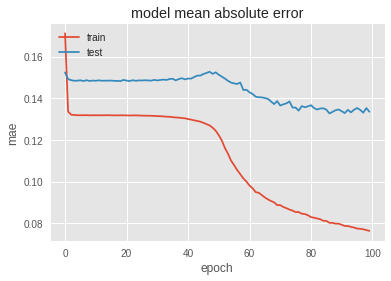

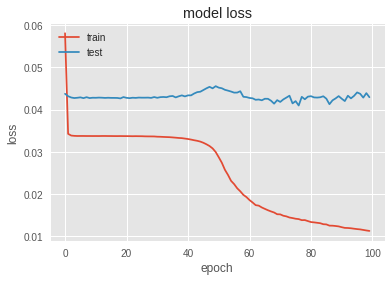

In [197]:
def visualize(history):
  plt.plot(history.history['mean_absolute_error'])
  plt.plot(history.history['val_mean_absolute_error'])
  plt.title('model mean absolute error')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
visualize(history)

In [31]:
img = test_images[0]
pre = model.predict(np.array([img]))
print(pre.shape)

(1, 30)


In [32]:
k = pre.reshape(-1,1)
k.shape

(30, 1)

In [0]:
pre1 = output_pipe.inverse_transform(pre).reshape(15, 2)

In [34]:
pre1.T

array([[67.25367 , 29.239536, 60.708427, 73.173874, 35.438824, 22.963078,
        59.015488, 80.1847  , 36.990204, 15.767333, 48.532547, 62.2255  ,
        33.06532 , 47.888557, 47.77561 ],
       [37.82185 , 36.86214 , 38.271694, 39.082836, 37.57495 , 37.881657,
        26.163944, 30.97396 , 25.258698, 29.41784 , 51.97883 , 76.108604,
        76.151344, 67.86014 , 86.620636]], dtype=float32)

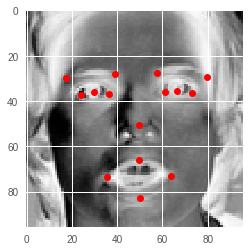

In [35]:
import random
k = random.randint(0, train_images.shape[0])
img = train_images[k]
pre = model.predict(np.array([img]))
pre = output_pipe.inverse_transform(pre).reshape(15,2)
x = pre.T[0]
y = pre.T[1]
plt.figure()
plt.plot(x,y, marker='o',linestyle='', color='r', label = "keypoints",)
plt.imshow(img.reshape(96,96))

# Using PCA to remove noise
Creating eigen faces using principle component analysis

In [154]:
reformed_imgs = train_images_1.reshape(-1, 96*96)
reformed_imgs.shape

(4280, 9216)

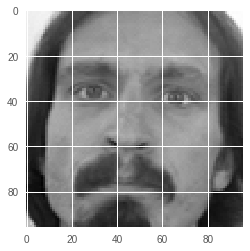

In [155]:
show_img(reformed_imgs[0])

In [227]:
from sklearn.decomposition import PCA

h, w = 96, 96

n_components = 1000

print("Extracting the top %d eigenfaces from %d faces" % (
    n_components, reformed_imgs.shape[0]))

pca = PCA(n_components=n_components, whiten=True, svd_solver='auto')

%time pca.fit(reformed_imgs)

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 1000 eigenfaces from 4280 faces
CPU times: user 33.7 s, sys: 3.53 s, total: 37.3 s
Wall time: 19.4 s


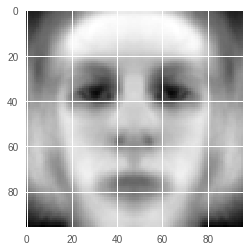

In [228]:
plt.imshow(eigenfaces[0], cmap='gray')

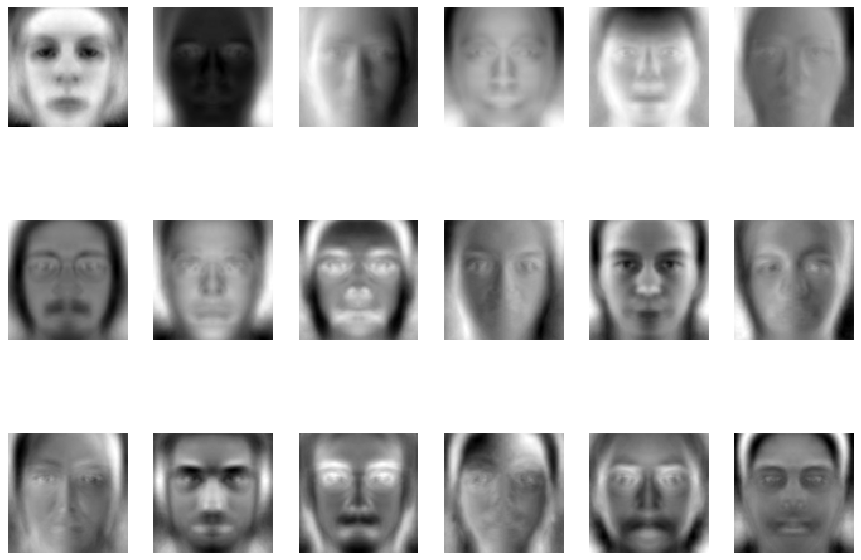

In [229]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(2.0* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        img = images[i]
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.imshow(img.reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

h, w = eigenfaces[0].shape

plot_gallery(eigenfaces, h, w)

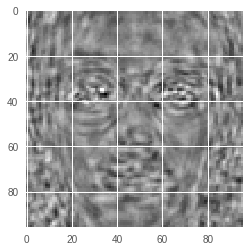

In [230]:
average = np.mean(eigenfaces, axis=0)
plt.imshow(average, cmap='gray')

### Denoising of image
mapping each image vector to a lower dimensional vector and then mapping it back to higher dimensional vector with reduced features

In [231]:
eg = train_images[10]
eg.shape

(96, 96, 1)

In [0]:
imvec = eg.flatten() - average.flatten()
output = average.copy()

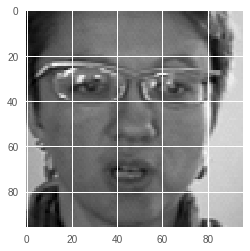

In [233]:
show_img(eg)

In [0]:
for i in eigenfaces:
    w = np.dot(imvec, i.flatten())
    output = output + i*w

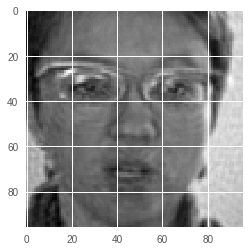

In [235]:
show_img(output)

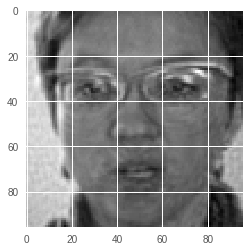

In [236]:
import cv2
output1 = eigenfaces[0].copy()
for i in eigenfaces:
    w = np.dot(imvec, i.flatten())
    output1 = output1 + i*w
show_img(cv2.flip(output1, 1))

In [0]:
def denoisify(images, eigenfaces):
  average = np.mean(eigenfaces, axis=0)
  denoised_imgs = []
  for img in images:
    
    imvec = img.flatten() - average.flatten()
    output = average.copy()
    
    for i in eigenfaces:
      w = np.dot(imvec, i.flatten())
      output = output + i*w
    output = output.reshape(96,96,1)
    denoised_imgs.append(output)
  return np.array(denoised_imgs)

In [0]:
denoised_img = denoisify(train_images_1, eigenfaces)

In [239]:
denoised_img.shape

(4280, 96, 96, 1)

In [0]:
model1 = create_model()

# sgd = optimizers.SGD(lr=0.1, decay=1e-5, momentum=0.96, nesterov=True)
model1.compile(optimizer='sgd', loss='mse', metrics=['mae'])

In [0]:
epochs = 100
history1 = model1.fit(denoised_img, train_keypoints_1, 
                 validation_split=0.3, shuffle=True, 
                 epochs=epochs, batch_size=128)

Train on 2996 samples, validate on 1284 samples
Epoch 1/100
2996/2996 [==============================] - 4s 1ms/step - loss: 0.0984 - mean_absolute_error: 0.2488 - val_loss: 0.0964 - val_mean_absolute_error: 0.2500
Epoch 2/100
2996/2996 [==============================] - 2s 580us/step - loss: 0.0702 - mean_absolute_error: 0.2096 - val_loss: 0.0875 - val_mean_absolute_error: 0.2381
Epoch 3/100
2996/2996 [==============================] - 2s 580us/step - loss: 0.0605 - mean_absolute_error: 0.1930 - val_loss: 0.0831 - val_mean_absolute_error: 0.2319
Epoch 4/100
2996/2996 [==============================] - 2s 583us/step - loss: 0.0549 - mean_absolute_error: 0.1824 - val_loss: 0.0803 - val_mean_absolute_error: 0.2279
Epoch 5/100
2996/2996 [==============================] - 2s 580us/step - loss: 0.0516 - mean_absolute_error: 0.1760 - val_loss: 0.0785 - val_mean_absolute_error: 0.2252
Epoch 6/100
2996/2996 [==============================] - 2s 581us/step - loss: 0.0491 - mean_absolute_error: 

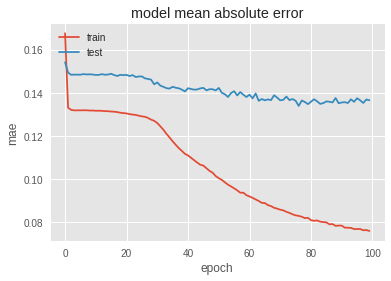

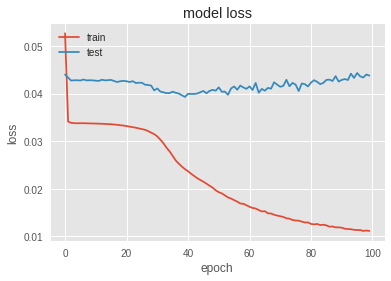

In [242]:
visualize(history1)